# SIR Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
%matplotlib inline

The EpidemicModel class implements the base model. Its method `time_evolution` runs the simulation
for given 
- recover_probas = $\mu_i(t)$ 
- transmissions = $\{i , j, \lambda_{ij}(t)\}$ (for i and j in contact at $t$)

The ProximityModel class corresponds to a simple model where
- recover_probas = $\mu$ is constant
- transmission rate = $\lambda$ is constant
- the contact network changes at each time step
- proba of contact = $\exp(-d(i,j)/s)$

In [2]:
from sir_model import ProximityModel
seed = 42
np.random.seed(seed)
model = ProximityModel(N=200, scale=1.2, mu=0.01, lamb=0.02)
print("expected number of contacts %.1f" % model.n_contacts)
model.run(200, print_every=100)

expected number of contacts 7.2
Generating transmissions
Running simulation
t = 0 / 200
t = 100 / 200


In [3]:
from ipywidgets import interact, IntSlider
interact(model.plot, t=IntSlider(min=0, max=100));

interactive(children=(IntSlider(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

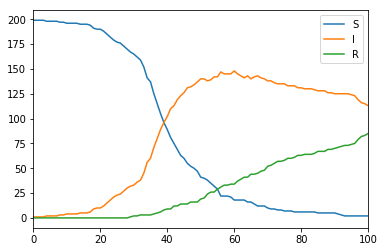

In [4]:
counts = model.get_counts()
counts.plot()
plt.xlim(0,100);

# Observations

Let's say there are random n_test for each t_test. For simplicity we suppose that the infection time is simply t_test - tau for some constant tau.

In [5]:
def generate_observations(model, tests, tau):
    observations = []
    for t_test, n_test in tests.items():
        tested = np.random.choice(model.N, n_test, replace=False)
        for i in tested:
            obs = dict(i=i, t_test=t_test, s=model.states[t_test,i])
            if model.states[t_test,i]==1:
                obs["tau"] = tau
            observations.append(obs)
    return observations

In [6]:
observations = generate_observations(model, tests={60: 25, 80: 25}, tau=4)
df_obs = pd.DataFrame(observations)
df_obs.head()

,i,s,t_test,tau
0,107,1.0,60,4.0
1,59,1.0,60,4.0
2,158,1.0,60,4.0
3,182,1.0,60,4.0
4,57,2.0,60,NaN


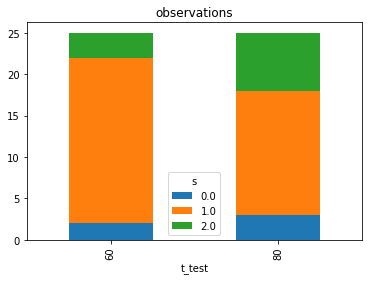

In [7]:
df_obs.groupby(["t_test", "s"]).size().unstack("s").plot.bar(
    stacked=True, title="observations"
);

# Inference

Let's say we start the inference at t_start, and use the actual frequencies 
as the initial proba.

In [8]:
from inference_model import MeanField

def generate_initial_probas(states):
    "generate initial proba according to the freq of states"
    freqs = [np.mean(states==s) for s in [0,1,2]]
    print("freqs = ", freqs)
    N = len(states)
    initial_probas = np.broadcast_to(freqs, (N, 3)).copy()
    return initial_probas

t_start = 40
initial_probas = generate_initial_probas(states=model.states[t_start])
infer = MeanField(initial_probas, model.x_pos, model.y_pos)

freqs =  [0.445, 0.51, 0.045]


**Warning** One must be careful to shift the transmissions and the observations by t_start

In [9]:
transmissions = model.transmissions[t_start:]
for obs in observations:
    obs["t"] = obs["t_test"]-t_start
    if obs["s"]==1:
        obs["t_I"] = obs["t"] - obs["tau"]
infer.time_evolution(model.recover_probas, transmissions, observations, print_every=100)

t = 0 / 160
t = 100 / 160


In [10]:
from ipywidgets import fixed, IntText
interact(
    infer.plot_probas_obs, t=IntText(min=0,max=100),
    model=fixed(model), observations=fixed(observations), t_start=fixed(t_start)
);

interactive(children=(IntText(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

# Comparing number of S, I or R people 

Actual (plain lines) vs inferred (dashed lines)

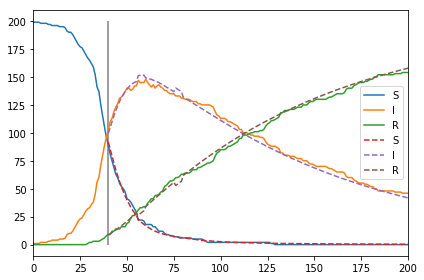

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
counts.plot(ax=ax)
counts_est = infer.get_counts()
counts_est.index += t_start
counts_est.plot(ax=ax, linestyle="--")
ax.vlines(t_start, 0, model.N, color="gray")
fig.tight_layout()